In [ ]:
import os
import cv2
from glob import glob

In [ ]:
# Set your image directory
IMAGE_DIR = '/content/modi'
OUT_DIR = '/content/pill'
###

all_image_path = glob(os.path.join(IMAGE_DIR, '*.png'))
imageid_path_dict = {(os.path.splitext(os.path.basename(x))[0]): x for x in all_image_path}
for imageid, path in imageid_path_dict.items():
    imageid = str(imageid)
    img = cv2.imread(path)
    w = img.shape[1] // 2
    left_img = img[:, 0: w]
    right_img = img[:, w: img.shape[1]]
    cv2.imwrite(os.path.join(OUT_DIR, imageid + '1.png'), left_img)
  
    print(imageid, "done")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
oval_yellow-201502341 done
circle_white-201506684 done
oval_blue-201207583 done
circle_white-200706530 done
oval_white-201206908 done
rectangle_yellowgreen-202103770 done
oval_yellow-201404170 done
circle_white-201400626 done
oval_orange-200704333 done
circle_white-200810766 done
circle_pink-200402541 done
oval_red-201206998 done
triangle_pink-200101598 done
circle_yellowgreen-201702252 done
rectangle,capsule_blue-201507620 done
oval_pink-200807075 done
rectangle_white-200401327 done
rectangle_white-200702577 done
square_orange-201702073 done
circle_white-200701642 done
triangle_white-201505100 done
circle_white-198200066 done
oval,capsule_bluegreen,trans-200400463 done
oval_white-202101674 done
circle_white-202002451 done
circle_yellow-201310780 done
rectangle,capsule_red-200403448 done
rectangle,capsule_blue-200000803 done
rectangle_brown-202102744 done
circle_yellow-200905926 done
circle_yellow-201603444 done
circle_pink-201500977 done
circle_oran

In [ ]:
cd "/content/modi"

In [ ]:
!unzip "/content/drive/MyDrive/nobg.zip"

In [ ]:
# 패키지 import
import matplotlib
matplotlib.use("Agg")

import os
import cv2
import random
import pickle
import argparse
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras_preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# input 이미지의 차원, 채널에 해당하는 축을 설정하여 모델을 초기화
	
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
 
 		# input 이미지의 차원을 알맞게 변경
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

    # CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
  

    # (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
 
		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
  

    # FC => RELU
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# 다중 라벨 분류
		model.add(Dense(classes))
		model.add(Activation(finalAct))
 
 		# 네트워크 아키텍처 반환
		return model

In [ ]:
EPOCHS = 75                 # 모든 학습 데이터셋을 학습하는 횟수
INIT_LR = 1e-3              # 학습률 => 1e-5 부터 시작하여 가장 적합해 보이는 학습률 채택
BS = 32                     # 일반적으로 성능이 뛰어난 32크기의 mini-batch 채택
IMAGE_DIMS = (96, 96, 3)    # 이미지 차원

In [ ]:
imagePaths="/content/pill"
file_list = os.listdir(imagePaths)

In [ ]:
len(file_list)

22158

In [ ]:
# 데이터와 라벨을 초기화
data = []
labels = []

# 이미지 전처리
for imagePath in file_list:
  image = cv2.imread('/content/pill/'+imagePath)
  # print(image)
  if image is not None : 
    image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # 라벨 리스트 업데이트
    l = label = imagePath.split("-")[0].split("_")
    labels.append(l)

data = np.array(data, dtype= np.float32) / 255.0
labels = np.array(labels)

In [ ]:
# 라벨 이진화 
print("라벨 리스트:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# 리스트에 있는 라벨들을 출력
for (i, label) in enumerate(mlb.classes_):
  print("{}. {}".format(i + 1, label))

라벨 리스트:
1. black
2. black,trans
3. blue
4. blue,light
5. blue,trans
6. bluegreen
7. bluegreen,trans
8. brown
9. brown,deep
10. brown,trans
11. circle
12. darkblue
13. darkblue,trans
14. etc
15. etc,capsule
16. gray
17. green
18. green,trans
19. hexagon
20. orange
21. orange,trans
22. oval
23. oval,capsule
24. pentagon
25. pink
26. pink,deep
27. pink,light
28. pink,trans
29. purple
30. purple,trans
31. rectangle
32. rectangle,capsule
33. red
34. red,trans
35. redpurple
36. redpurple,trans
37. rhombus
38. square
39. trans
40. triangle
41. triangle,capsule
42. white
43. white,blue
44. white,brown
45. white,green
46. white,orange,trans
47. white,red
48. white,trans
49. white,yellow
50. yellow
51. yellow,trans
52. yellowgreen
53. yellowgreen,trans


In [ ]:
# 학습 데이터와 테스트 데이터를 8:2 비율로 나눔
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

# 배열을 1개의 압축되지 않은 npz 포맷 파일로 저장
np.savez('/content/drive/MyDrive/train_data.npz', xtrain = trainX, ytrain = trainY)
np.savez('/content/drive/MyDrive/test_data.npz', xtest = testX, ytest = testY)

In [ ]:
# 이미지 augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# sigmoid 활성화 함수를 네트워크의 마지막 레이어로 설정
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")

# 옵티마이저를 초기화
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
# 네트워크 학습
print("네트워크 학습")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

네트워크 학습


<ipython-input-16-5fe5661be8f7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/75
553/553 [==============================] - 70s 98ms/step - loss: 0.1577 - accuracy: 0.2692 - val_loss: 0.1655 - val_accuracy: 0.3946
Epoch 2/75
553/553 [==============================] - 52s 94ms/step - loss: 0.0527 - accuracy: 0.3030 - val_loss: 0.0483 - val_accuracy: 0.5702
Epoch 3/75
553/553 [==============================] - 53s 97ms/step - loss: 0.0487 - accuracy: 0.3078 - val_loss: 0.0717 - val_accuracy: 0.3407
Epoch 4/75
553/553 [==============================] - 52s 94ms/step - loss: 0.0457 - accuracy: 0.3180 - val_loss: 0.0410 - val_accuracy: 0.5316
Epoch 5/75
553/553 [==============================] - 51s 92ms/step - loss: 0.0432 - accuracy: 0.3277 - val_loss: 0.1179 - val_accuracy: 0.5560
Epoch 6/75
553/553 [==============================] - 51s 92ms/step - loss: 0.0416 - accuracy: 0.3359 - val_loss: 0.0496 - val_accuracy: 0.5244
Epoch 7/75
553/553 [==============================] - 53s 95ms/step - loss: 0.0392 - accuracy: 0.3526 - val_loss: 0.0444 - val_accuracy:

In [ ]:
# 모델 저장
from keras.models import load_model

model.save('/content/drive/MyDrive/pill_model_modify.h5')

# MultiLabelBinarizer 저장
f = open('/content/drive/MyDrive/multilabelbin.txt', "wb")
f.write(pickle.dumps(mlb))
f.close()

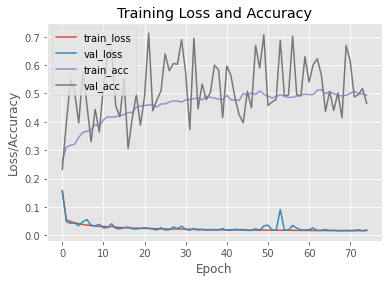

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
# 학습 로스와 정확도를 그래프로 확인
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()